In [1]:
import numpy as np
import matplotlib.pyplot as pyplot
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split, learning_curve, StratifiedShuffleSplit

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
##Data Aquisition
me_test_raw = np.load('LO_3_MG/3Jet_500000.npy', allow_pickle=True) #Matrix elements - test
mom_test_raw = np.load('LO_3_0.01_NJet/PS3_0.01_500000.npy', allow_pickle=True, encoding='bytes')#4-momenta of inputs - test
mom_test_raw = np.array([np.array(element) for element in mom_test_raw])

me_train_raw = np.load('LO_3_MG/3Jet_3000000.npy', allow_pickle=True) #Matrix elements - train
mom_train_raw = np.load('LO_3_0.01_NJet/PS3_0.01_3000000.npy', allow_pickle=True, encoding='bytes') #4-momenta of input - train
mom_train_raw = np.array([np.array(element) for element in mom_train_raw])

Adding some extra features

In [3]:
##Minkowski product of 4-vectors p1, p2.
def m_prod_arr(p1, p2):
    return np.multiply(p1[:,0], p2[:,0]) - np.sum(np.multiply(p1[:,1:], p2[:,1:]), axis=1)

In [4]:
p_12tr = mom_train_raw[:,2] + mom_train_raw[:,3] #p1+p2
p_13tr = mom_train_raw[:,2] + mom_train_raw[:,4] #p1+p3
p_23tr = mom_train_raw[:,3] + mom_train_raw[:,4] #p2+p3

p_12te = mom_test_raw[:,2] + mom_test_raw[:,3] #p1+p2
p_13te = mom_test_raw[:,2] + mom_test_raw[:,4] #p1+p3
p_23te = mom_test_raw[:,3] + mom_test_raw[:,4] #p2+p3

s_12tr = m_prod_arr(p_12tr, p_12tr) #center of mass energyies of two of three beams
s_13tr = m_prod_arr(p_13tr, p_13tr)
s_23tr = m_prod_arr(p_23tr, p_23tr)

s_12te = m_prod_arr(p_12te, p_12te)
s_13te = m_prod_arr(p_13te, p_13te)
s_23te = m_prod_arr(p_23te, p_23te)


## Single Test

In [5]:
##Reformat Momentum
mom_train = np.array([np.ndarray.flatten(np.array(element)[2:]) for element in mom_train_raw])
mom_test = np.array([np.ndarray.flatten(np.array(element)[2:]) for element in mom_test_raw])

##Reformat Matrix Element
me_train = np.multiply(np.multiply(me_train_raw, s_13tr), s_23tr)/(s_12tr+s_13tr+s_23tr)
me_test = np.multiply(np.multiply(me_test_raw, s_13te), s_23te)/(s_12te+s_13te+s_23te)


##Data transformation
pipeline = Pipeline([
    ('scaler', StandardScaler()), #Rescale Data.
    ('kbins', KBinsDiscretizer(n_bins=1200)) #Checking convergence as bins.
])
 
mom_train = pipeline.fit_transform(mom_train) #Rescale on training set
mom_test = pipeline.transform(mom_test) #Rescale on test set

In [6]:
linreg = LinearRegression().fit(mom_train, me_train)

me_predict_lin = linreg.predict(mom_test) #Prediction on test set
lin_mse = mean_squared_error(me_test, me_predict_lin) 
print(lin_mse)
print(np.sqrt(lin_mse))


lin_perc = np.mean(100*np.divide(np.abs(me_test - me_predict_lin), me_test))
print(lin_perc)

5.2471394781601385e-09
7.243714156536091e-05
0.057031997232973426


In [7]:
print(np.std(me_test))

0.024803181637985238


## Plotting Learning Curve

In [23]:
##Plotting a Learning Curve
split = StratifiedShuffleSplit() #Collects data evenly about mean to put into validation sets
train = split.split(mom_train, pd.cut(me_train, bins = 200)) #But are we testing on something we've trained..?

train_sizes, train_scores, test_scores = learning_curve(
        linreg, mom_train, me_train, scoring='neg_mean_squared_error',
        cv=5, shuffle=True, train_sizes=np.linspace(0.01, 0.1, 15), 
        n_jobs=1, verbose=1)

[learning_curve] Training set sizes: [ 24000  39428  54857  70285  85714 101142 116571 132000 147428 162857
 178285 193714 209142 224571 240000]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    5.3s finished


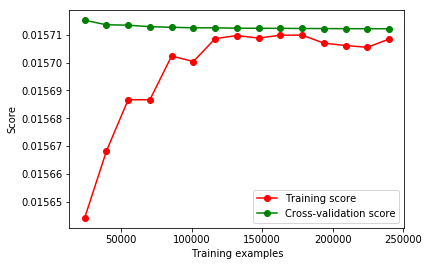

In [24]:
pyplot.figure()

train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))
test_scores_mean = np.sqrt(-np.mean(test_scores, axis=1))

pyplot.xlabel("Training examples")
pyplot.ylabel("Score")
pyplot.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
pyplot.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

pyplot.legend(loc="best")

In [12]:
np.std(me_test)

0.024803181637985238

## Plot accuracy vs number of bins

In [5]:
def changeBins(n_bins, input_train, input_test, output_train, output_test):
    ##Data transformation
    pipeline = Pipeline([
        ('scaler', StandardScaler()), #Rescale Data.
        ('kbins', KBinsDiscretizer(n_bins=n_bins)) #Checking convergence as bins.
    ])

    temp_train = pipeline.fit_transform(input_train) #Rescale on training set
    temp_test = pipeline.transform(input_test) #Rescale on test set
    
    linreg = LinearRegression().fit(temp_train, output_train)

    me_predict = linreg.predict(temp_test) #Prediction on test set
    lin_mse = mean_squared_error(output_test, me_predict) 
    
    return np.sqrt(lin_mse)

In [21]:
##Reformat Momentum
mom_train = np.array([np.ndarray.flatten(np.array(element)[2:]) for element in mom_train_raw])
mom_test = np.array([np.ndarray.flatten(np.array(element)[2:]) for element in mom_test_raw])

##Reformat Matrix Element
me_train = np.multiply(np.multiply(me_train_raw, s_13tr), s_23tr)/(s_12tr+s_13tr+s_23tr)
me_test = np.multiply(np.multiply(me_test_raw, s_13te), s_23te)/(s_12te+s_13te+s_23te)

n_bins_arr = range(100000, 150000, 5000)
result = []
for n_bins in n_bins_arr:
    temp = changeBins(n_bins, mom_train, mom_test, me_train, me_test)
    print(temp)
    result.append(temp)

1.5155934822585473e-06
1.4601332153269125e-06
1.4276628655441308e-06
1.3991790643439597e-06
1.3745689592476353e-06
1.3550931254382378e-06
1.3371902537080522e-06
1.3166715710008728e-06
1.3123495758045727e-06
1.3013149582577112e-06


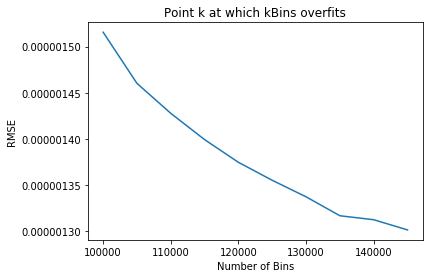

In [22]:
pyplot.xlabel('Number of Bins')
pyplot.ylabel('RMSE')
pyplot.title('Point k at which kBins overfits')
pyplot.plot(n_bins_arr, result)
pyplot.savefig('RMSE_kBins_Overfit')

In [ ]:
print(np.mean(me_test))

In [ ]:
print(np.std(me_test))